In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import re

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())


In [165]:

# 1. 데이터 로드
train = pd.read_csv('/apps/study_promptengineerings/dacon/debt_risk/train.csv')
test = pd.read_csv('/apps/study_promptengineerings/dacon/debt_risk/test.csv')

# ID 매핑 저장 및 컬럼 제거
id_mapping = pd.Series(test['UID'].values, index=test.index)
train = train.drop('UID', axis=1)
test = test.drop('UID', axis=1)

# 결측치 확인
print("Train set missing values:")
print(train.isnull().sum())
print("\nTest set missing values:")
print(test.isnull().sum())


Train set missing values:
주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
채무 불이행 여부            0
dtype: int64

Test set missing values:
주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
dtype: int64


In [166]:
# 숫자만 남기고 나머지 제거하는 함수
def extract_numbers(value):
    if isinstance(value, str):  # 문자열인 경우만 처리
        result = re.sub(r'[^0-9]', '', value)  # 숫자가 아닌 문자는 제거
        return int(result) if result else None  # 숫자로 변환, 없으면 None 반환
    return value  # 원래 숫자인 경우 그대로 반환

# 특정 컬럼에 숫자만 남기기
train['현재 직장 근속 연수'] = train['현재 직장 근속 연수'].apply(extract_numbers)

In [167]:
# 2. Feature Engineering
# 레이블 인코딩 적용

label_columns = ['개인 파산 횟수', '현재 직장 근속 연수', '개설된 신용계좌 수', '신용 거래 연수', '신용 문제 발생 횟수', '체납 세금 압류 횟수', '마지막 연체 이후 경과 개월 수']

# 레이블 인코딩 적용
label_encoder = LabelEncoder()

for col in label_columns:
    # 각 컬럼에 대해 레이블 인코딩 수행
    train[col] = label_encoder.fit_transform(train[col])

# 결과 출력
print(train)

                주거 형태      연간 소득  현재 직장 근속 연수  체납 세금 압류 횟수  개설된 신용계좌 수  \
0                  자가  1941337.5            9            0           7   
1                  월세  1979505.0            9            0           3   
2                  월세  1356381.0            3            0          10   
3                  월세  1049017.5            5            0          13   
4                  월세  4320217.5            1            0           9   
...               ...        ...          ...          ...         ...   
9995  주택 담보 대출 (거주 중)  1339473.0            9            0           7   
9996  주택 담보 대출 (거주 중)  2297230.5            1            0           9   
9997  주택 담보 대출 (거주 중)  1221523.5            9            0           7   
9998               자가  3343584.0            9            0           8   
9999  주택 담보 대출 (거주 중)  2175133.5            4            0           3   

      신용 거래 연수   최대 신용한도  신용 문제 발생 횟수  마지막 연체 이후 경과 개월 수  개인 파산 횟수   대출 목적  \
0           66  400597.5         

In [168]:
# # 원-핫 인코더 초기화
# encoder = OneHotEncoder(sparse=True)

# # train 데이터에 대해 원-핫 인코딩 적용
# train_encoded = encoder.fit_transform(train[['주거 형태', '대출 목적', '대출 상환 기간']])
# train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['주거 형태', '대출 목적', '대출 상환 기간']))

# # test 데이터에 대해 원-핫 인코딩 적용
# test_encoded = encoder.transform(test[['주거 형태', '대출 목적', '대출 상환 기간']])
# test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['주거 형태', '대출 목적', '대출 상환 기간']))

# # 원래 데이터프레임과 인코딩된 데이터프레임 결합
# train = pd.concat([train.reset_index(drop=True), train_encoded_df.reset_index(drop=True)], axis=1)
# test = pd.concat([test.reset_index(drop=True), test_encoded_df.reset_index(drop=True)], axis=1)

# # 결과 출력
# print("Train 데이터프레임:")
# print(train)
# print("\nTest 데이터프레임:")
# print(test)


from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 원-핫 인코더 초기화 (drop='first' 제거, sparse=True 설정)
encoder = OneHotEncoder(sparse=True)

# train 데이터에 대해 원-핫 인코딩 적용
encoder.fit(train[['주거 형태', '대출 목적', '대출 상환 기간']])
train_encoded = encoder.transform(train[['주거 형태', '대출 목적', '대출 상환 기간']])
train_encoded_df = pd.DataFrame.sparse.from_spmatrix(
    train_encoded, 
    columns=encoder.get_feature_names_out(['주거 형태', '대출 목적', '대출 상환 기간'])
)

# test 데이터에 대해 원-핫 인코딩 적용
test_encoded = encoder.transform(test[['주거 형태', '대출 목적', '대출 상환 기간']])
test_encoded_df = pd.DataFrame.sparse.from_spmatrix(
    test_encoded, 
    columns=encoder.get_feature_names_out(['주거 형태', '대출 목적', '대출 상환 기간'])
)

# 원래 데이터프레임과 인코딩된 데이터프레임 결합
train = pd.concat([train.reset_index(drop=True), train_encoded_df.reset_index(drop=True)], axis=1)
test = pd.concat([test.reset_index(drop=True), test_encoded_df.reset_index(drop=True)], axis=1)

# 결과 출력
print("Train 데이터프레임:")
print(train)
print("\nTest 데이터프레임:")
print(test)


Train 데이터프레임:
                주거 형태      연간 소득  현재 직장 근속 연수  체납 세금 압류 횟수  개설된 신용계좌 수  \
0                  자가  1941337.5            9            0           7   
1                  월세  1979505.0            9            0           3   
2                  월세  1356381.0            3            0          10   
3                  월세  1049017.5            5            0          13   
4                  월세  4320217.5            1            0           9   
...               ...        ...          ...          ...         ...   
9995  주택 담보 대출 (거주 중)  1339473.0            9            0           7   
9996  주택 담보 대출 (거주 중)  2297230.5            1            0           9   
9997  주택 담보 대출 (거주 중)  1221523.5            9            0           7   
9998               자가  3343584.0            9            0           8   
9999  주택 담보 대출 (거주 중)  2175133.5            4            0           3   

      신용 거래 연수   최대 신용한도  신용 문제 발생 횟수  마지막 연체 이후 경과 개월 수  개인 파산 횟수  ...  \
0           66  400597

In [169]:

# 수치형 변수 스케일링
scaler = StandardScaler()
num_features = ['연간 소득', '최대 신용한도', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수']
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])


In [170]:

# 3. 데이터 준비
X = train.drop('채무 불이행 여부', axis=1)
y = train['채무 불이행 여부']

# 클래스 가중치 계산
class_weights = dict(zip(
    np.unique(y),
    1 / np.bincount(y) * len(y) / 2
))


In [171]:

# 4. Stacking 모델 구성
# Base models
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=0.1,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    random_seed=42,
    loss_function='Logloss',
    eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
    class_weights=[1, class_weights[1] / class_weights[0]]
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    class_weight='balanced'
)

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=class_weights[1] / class_weights[0]
)

# Meta model (Logistic Regression)
meta_model = LogisticRegression()

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('lightgbm', lgb_model),
        ('xgboost', xgb_model)
    ],
    final_estimator=meta_model,
    cv=5
)



OOF F1 Score: 0.3972


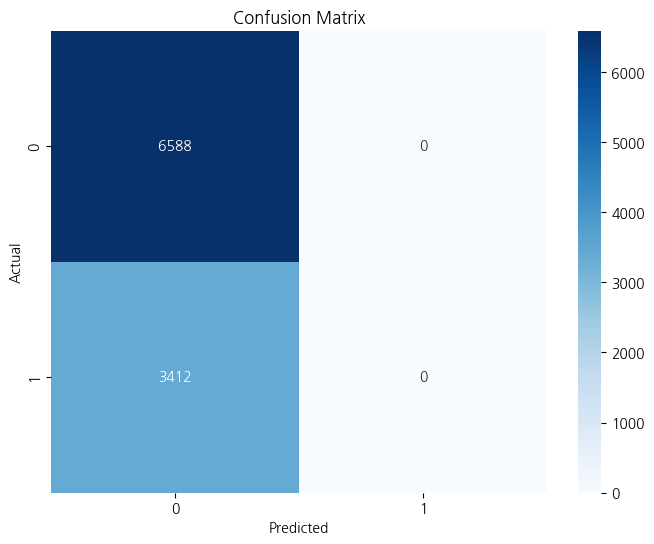

Submission file has been created successfully!


In [172]:

# 6. 모델 평가
oof_preds_binary = (oof_preds > 0.5).astype(int)
f1 = f1_score(y, oof_preds_binary, average='macro')
print(f"\nOOF F1 Score: {f1:.4f}")

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. 제출 파일 생성
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({
    'UID': id_mapping,
    '채무 불이행 확률': test_preds_binary
})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created successfully!")


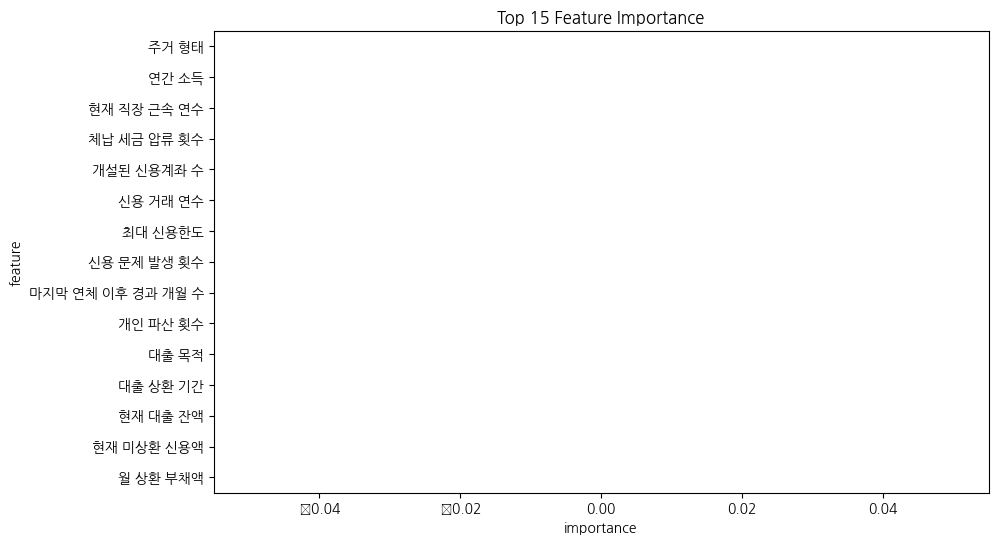

In [173]:

# 8. 특성 중요도 시각화 (CatBoost 기준)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': catboost_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.show()